In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tensorflow import keras
import tensorflow as tf


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [ ]:
path = '/content/drive/MyDrive/CNM/dataset'
path1 = '/content/drive/MyDrive/CNM_final/dataset2'

In [ ]:
classes_name = os.listdir(path)
classes_name

['with_mask', 'without_mask']

In [ ]:
classes = {}
for ele in classes_name:
  class_dir = os.path.join(path, ele)
  classes[ele] = len(os.listdir(class_dir))

In [ ]:
classes

{'with_mask': 2165, 'without_mask': 1930}

In [ ]:
import pandas as pd
import seaborn as sns

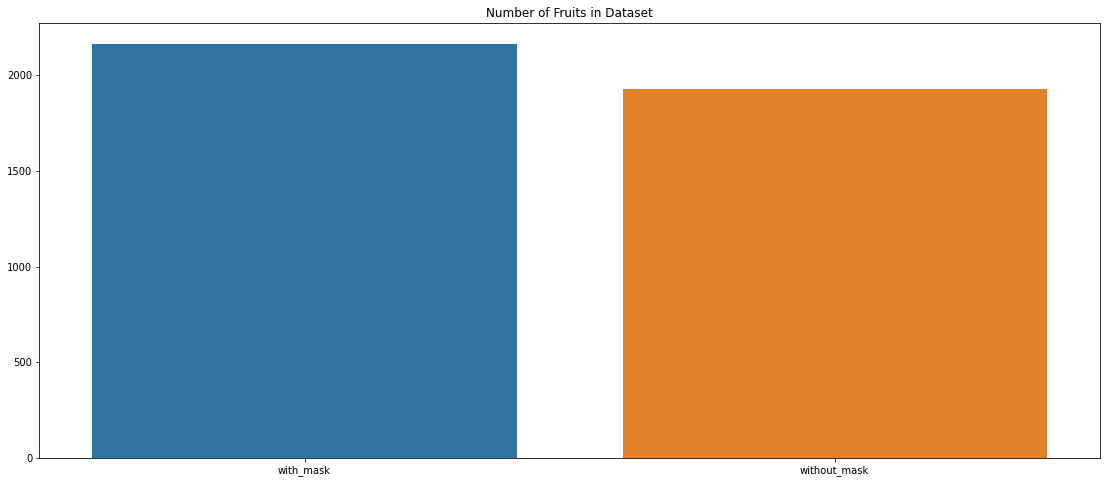

In [ ]:
df = pd.DataFrame(classes,index = [ i for i in range(len(classes)) ])
plt.figure(figsize=(19,8))
sns.barplot(data=df)
plt.title('Number of images in Dataset');

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.image as mpimg
import random
import cv2
import sys
from google.colab.patches import cv2_imshow

(187, 117, 3)


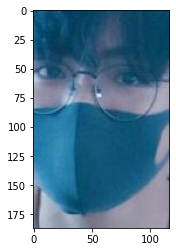

In [ ]:
random_class = os.path.join(path, random.choice(classes_name))
random_img = os.listdir(random_class)
img = mpimg.imread(os.path.join(random_class, random_img[565]))
plt.imshow(img)
print(img.shape)

Found 0 faces!


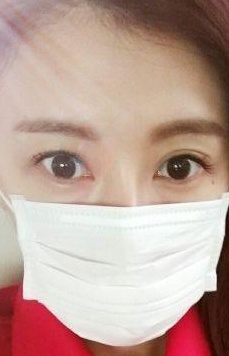

In [ ]:
imagePath = os.path.join(random_class, random_img[455])
cascPath = "/content/drive/MyDrive/CNM/haarcascade_frontalface_default.xml"

# cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
# faceCascade = cv2.CascadeClassifier(cascPath)

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

# Read the image
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(224, 224),
    flags=cv2.CASCADE_SCALE_IMAGE
)

print("Found {} faces!".format(len(faces)))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.putText(image, 'ajh', (x, y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, 'ajh', (x, y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    

cv2_imshow(image)


In [ ]:
X = []
Y = []

In [ ]:
# def make_dataset(path, class_name):
#   class_dir = os.path.join(path, class_name)
#   for i in range(len(os.listdir(class_dir))):
#     if os.listdir(class_dir)[i] == '.DS_Store':
#       break
#     img = mpimg.imread(os.path.join(class_dir, os.listdir(class_dir)[i]))
#     img = cv2.resize(img,(224,224))
#     X.append(img)
#     Y.append(class_name)
#   return X, Y

In [ ]:
# for label in classes_name:
#   X, Y = make_dataset(path, label)

In [ ]:
imagePaths = list(paths.list_images(path))


In [ ]:
len(imagePaths)

4092

In [ ]:
for image in list(paths.list_images(path1)):
  imagePaths.append(image)

In [ ]:
len(imagePaths)

4404

In [ ]:
data = []
labels = []

In [ ]:
for imagePath in imagePaths:
	#label
	label = imagePath.split(os.path.sep)[-2]

	#load anh va tien xu ly
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# them vao data , labels
	data.append(image)
	labels.append(label)

# chuyen sang numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels)

# one-hot encoding labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
len(labels)

4404

In [ ]:
#chia tap train va test
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False


opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#training
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
110/110 [==============================] - 179s 2s/step - loss: 0.4080 - accuracy: 0.8359 - val_loss: 0.1641 - val_accuracy: 0.9682
Epoch 2/20
110/110 [==============================] - 173s 2s/step - loss: 0.1793 - accuracy: 0.9436 - val_loss: 0.1006 - val_accuracy: 0.9750
Epoch 3/20
110/110 [==============================] - 172s 2s/step - loss: 0.1352 - accuracy: 0.9585 - val_loss: 0.0817 - val_accuracy: 0.9773
Epoch 4/20
110/110 [==============================] - 173s 2s/step - loss: 0.1213 - accuracy: 0.9596 - val_loss: 0.0716 - val_accuracy: 0.9796
Epoch 5/20
110/110 [==============================] - 171s 2s/step - loss: 0.1097 - accuracy: 0.9662 - val_loss: 0.0639 - val_accuracy: 0.9841
Epoch 6/20
110/110 [==============================] - 168s 2s/step - loss: 0.1025 - accuracy: 0.9699 - val_loss: 0.0652 - val_accuracy: 0.9784
Epoch 7/20
110/110 [==============================] - 174s 2s/step - loss: 0.0988 - accuracy: 0.9696 - val_loss: 0.0575 - val_accuracy: 0.9807

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


model.save("/content/drive/MyDrive/CNM_final/model/model.h5")

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       475
without_mask       0.99      0.99      0.99       406

    accuracy                           0.99       881
   macro avg       0.99      0.99      0.99       881
weighted avg       0.99      0.99      0.99       881



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


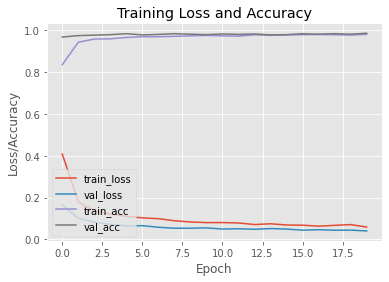

In [ ]:
#Loss và accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/CNM_final/plot")

In [ ]:
img_path = '/content/maksssksksss643.png'
img = cv2.imread(img_path)
cv2_imshow(img)
img = cv2.resize(img,(224,224))
predictions_single = model.predict(np.array([img]))
label = np.argmax(predictions_single[0])
print(label)